# Midterm 1, Assignment 2 - Gaetano Barresi

Relevant Information:
- The dataset collects data from a wearable accelerometer mounted on the chest
- Sampling frequency of the accelerometer: 52 Hz
- Accelerometer Data are Uncalibrated
- Number of Participants: 15
- Number of Activities: 7

Dataset Information
- Data are separated by participant
- Each file contains the following information
    - sequential number, x acceleration, y acceleration, z acceleration, label 
- Labels are codified by numbers
    - 1: Working at Computer
    - 2: Standing Up, Walking and Going up\down stairs
    - 3: Standing
    - 4: Walking
    - 5: Going Up\Down Stairs
    - 6: Walking and Talking with Someone
    - 7: Talking while Standing


The chosen participant for my analysis was subject number 2.
First of all, let's try to load the dataset and plot the time series for one of the activities: walking.

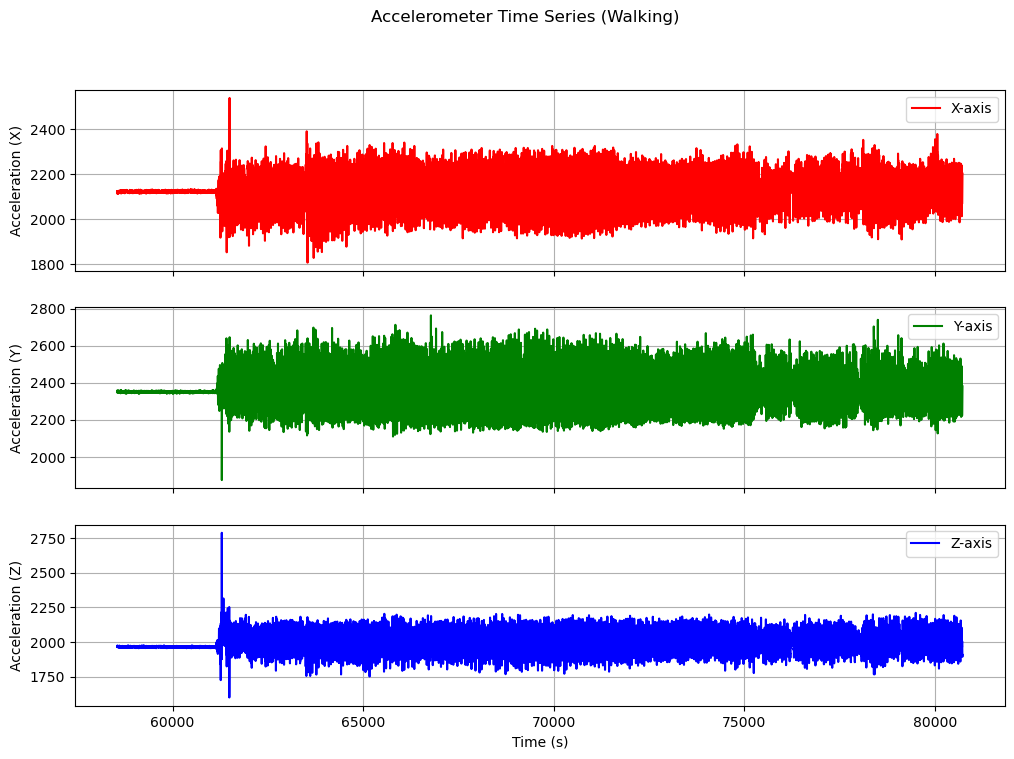

In [21]:
import pywt
import scipy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


def plot_time_series(data, activity):
    """
    Plots the 3 channels of the time series data.

    Parameters:
    data (pandas.DataFrame): The time series data.
    activity (str): The activity name to be used in the title.
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(data['Time'], data['X'], color='r', label="X-axis")
    axes[0].set_ylabel("Acceleration (X)")
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(data['Time'], data['Y'], color='g', label="Y-axis")
    axes[1].set_ylabel("Acceleration (Y)")
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(data['Time'], data['Z'], color='b', label="Z-axis")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Acceleration (Z)")
    axes[2].legend()
    axes[2].grid()

    plt.suptitle(f"Accelerometer Time Series ({activity})")
    plt.show()

#####################################################################à

column_names = ['Time', 'X', 'Y', 'Z', 'Label']
PARTICIPANT = 2
data = pd.read_csv(f'./dataset/{PARTICIPANT}.csv', header=None, names=column_names) #load the data

walking = data[data['Label'] == 4]
plot_time_series(walking, "Walking")

The first things that we can see are:
- the accelerometer values are strange;
- Time (s) presents the sample's sequential number, not the time in seconds.

Let's plot the spectrogram of these signals. The wavelet family used to perform the Continuos Wavelet Transform (CWT) is the Mexican Hat.

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


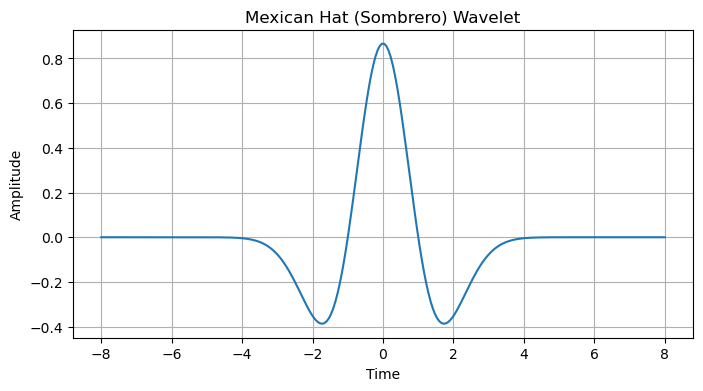

In [22]:
sombrero = pywt.ContinuousWavelet('mexh')
print(sombrero)

plt.figure(figsize=(8, 4))
sombrero_wavelet = sombrero.wavefun()
plt.plot(sombrero_wavelet[1], sombrero_wavelet[0])
plt.title("Mexican Hat (Sombrero) Wavelet")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

The following function `plot_cwt_spectrograms()` perfroms the CWT and then plot the spectrograms for signals in X, Y and Z axes.

The CWT operates on scales, not frequencies directly. Scales are inversely proportional to frequencies and the relationship between scale *a* and frequency *f* is given by:

$$
a = \frac{f_c \cdot f_s}{f}
$$

Where:
- *f_c*​ is the center frequency of the wavelet;

- *f_s* is the sampling frequency;

- *f* is the frequency of interest.

Before calling the funciton `pywt.cwt()` which perfroms the transformation, is important to set a good scale specifying the frequency range of interest to analyze.
Every activity has a typical frequency range and for the activities involved in this analysis they are:

**1. Working at Computer**: ~0 - 0.3 Hz

**2. Standing Up, Walking and Going Up/Down Stairs**: ~0.5 - 3.5 Hz

**3. Standing**: ~0 - 0.3 Hz

**4. Walking**: ~0.8 - 2 Hz

**5. Going Up/Down Stairs**: ~1.5 - 3 Hz

**6. Walking and Talking with Someone**: ~0.8 - 2.5 Hz

**7. Talking while Standing**: ~0 - 0.5 Hz

So, when I write:

`scales = fc * fs / np.array([f_max, f_min])`

`scales = np.linspace(scales[0], scales[1], num=100)`

I'm building a scaled representation of frequencies for the CWT, specifying the minimum and maximum frequencies. For our sombrero wavelet, the center frequency is 0.25 and the frequency sampling of the accelerometer is 52Hz.
Finally, with

`coeff_x, freq_x = pywt.cwt(data['X'], scales, wavelet, sampling_period=1/fs)`

I'm computing the CWT coefficients for each axes (X in this case). These are complex numbers representing the amplitude and phase of the signal at each scale and time.
`freq_x` are the frequencies corresponding to the scales.
The function concludes with the plot of the spectrograms.

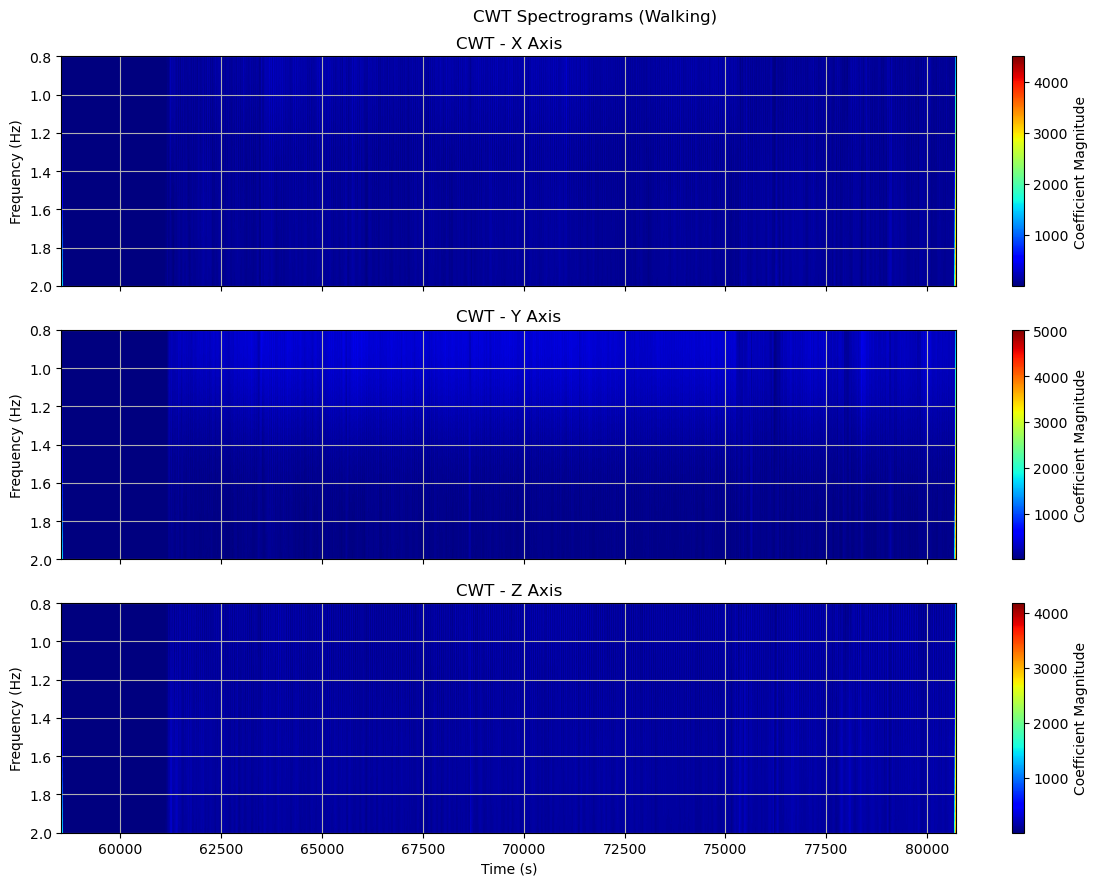

In [23]:
def plot_cwt_spectrograms(data, wavelet, activity, fs=52, f_min=1, f_max=5, fc=0.25):
    # Convert frequencies to scales
    scales = fc * fs / np.array([f_max, f_min]) # fc = 0.25 for Mexican Hat wavelet
    scales = np.linspace(scales[0], scales[1], num=100)  # 100 scales

    # Perform CWT for each signal
    coeff_x, freq_x = pywt.cwt(data['X'], scales, wavelet, sampling_period=1/fs)
    coeff_y, freq_y = pywt.cwt(data['Y'], scales, wavelet, sampling_period=1/fs)
    coeff_z, freq_z = pywt.cwt(data['Z'], scales, wavelet, sampling_period=1/fs)

    # Plot CWT spectrograms
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    cax_x = axes[0].imshow(np.abs(coeff_x), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_x.max(), freq_x.min()], cmap='jet')
    axes[0].set_title("CWT - X Axis")
    axes[0].set_ylabel("Frequency (Hz)")
    axes[0].grid()
    fig.colorbar(cax_x, ax=axes[0], orientation='vertical', label='Coefficient Magnitude')

    cax_y = axes[1].imshow(np.abs(coeff_y), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_y.max(), freq_y.min()], cmap='jet')
    axes[1].set_title("CWT - Y Axis")
    axes[1].set_ylabel("Frequency (Hz)")
    axes[1].grid()
    fig.colorbar(cax_y, ax=axes[1], orientation='vertical', label='Coefficient Magnitude')

    cax_z = axes[2].imshow(np.abs(coeff_z), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_z.max(), freq_z.min()], cmap='jet')
    axes[2].set_title("CWT - Z Axis")
    axes[2].set_ylabel("Frequency (Hz)")
    axes[2].set_xlabel("Time (s)")
    axes[2].grid()
    fig.colorbar(cax_z, ax=axes[2], orientation='vertical', label='Coefficient Magnitude')
    
    plt.suptitle(f"CWT Spectrograms ({activity})")
    plt.tight_layout()
    plt.show()

#################################################################

plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

As we can see, is impossible to use the dataset as it is. We need to rescale the accelerometer's values and convert the time values. I can compute time in seconds through the following formula:


$$
t = \frac{N}{f_s}
$$


Where:
- *t* is the time in seconds,
- *N* is the number of samples,
- *f_s* is the sampling frequency.

For accelerometer's values, I'm using a StandardScaler. It standardize features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:


$$
z = \frac{x - u}{s}
$$


Where:
- *u* is the mean,
- *s* is the standard deviation.

The function `preprocess_data()` applies the discussed changes to the data.

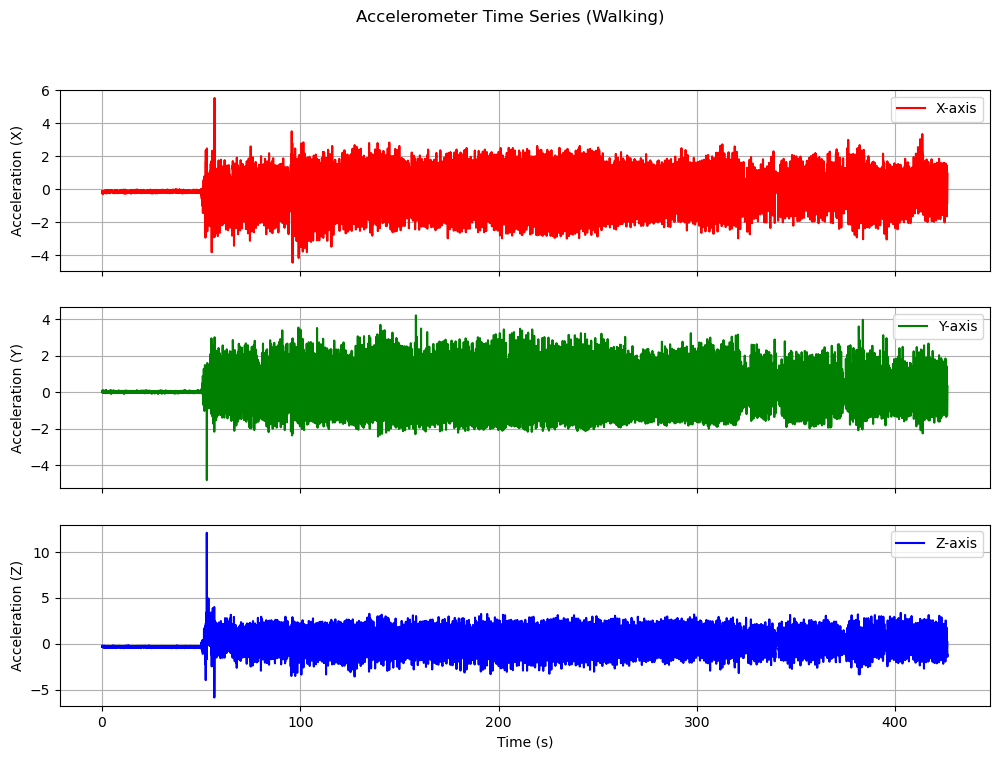

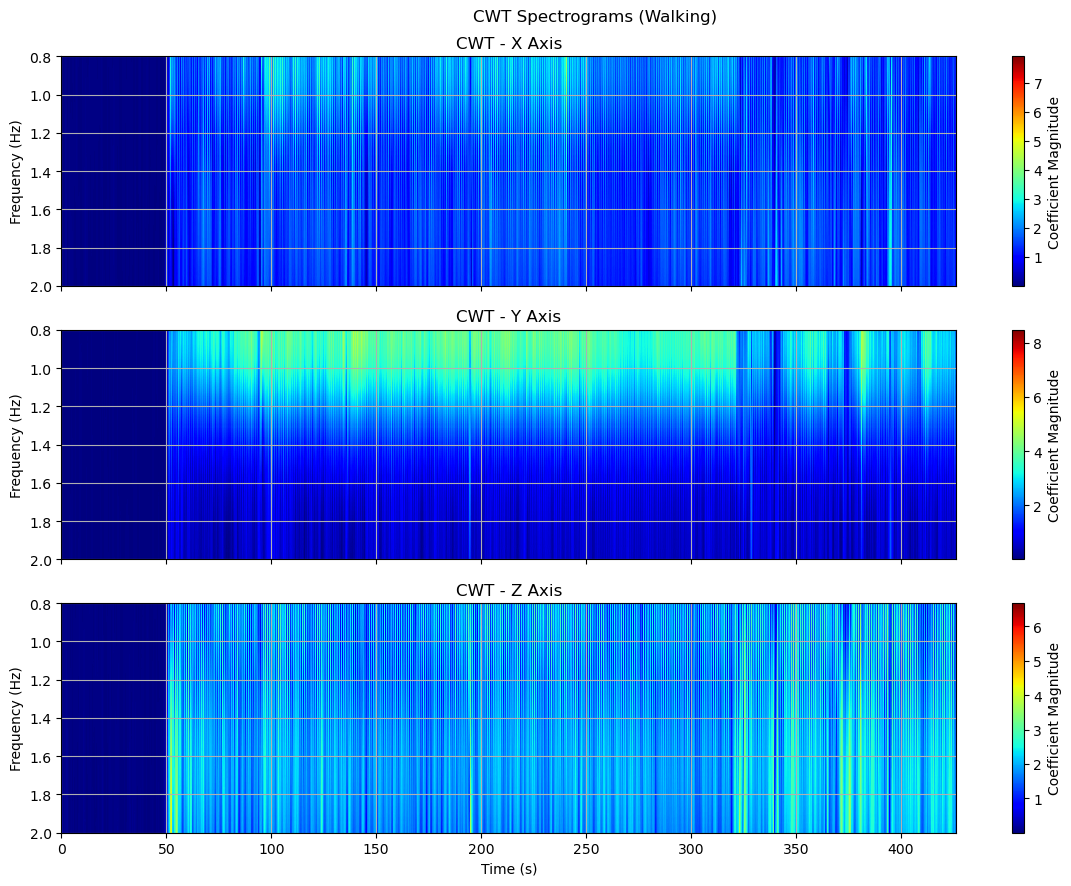

In [24]:
def low_pass_filter(data, f, threshold = 1):
    # Create the low pass butterworth filter that will filter at a frequency equal to the threshold
    b, a = scipy.signal.butter(8, threshold, 'low', fs=f)
    # Apply the filter to the data
    data['X'] = scipy.signal.filtfilt(b, a, data['X'])
    data['Y'] = scipy.signal.filtfilt(b, a, data['Y'])
    data['Z'] = scipy.signal.filtfilt(b, a, data['Z'])
    return data

def preprocess_data(data, fs=52, low_pass=False, low_pass_freq=1):
    new_data = data[['Time', 'X', 'Y', 'Z']].copy()

    if 'Sec' in data.columns:
        new_data['Time'] = data['Sec']
    else:
        # Compute time based on the sampling frequency of 52 Hz
        sample_numbers = np.arange(len(data))
        time = sample_numbers / fs  # Time in seconds
        new_data['Time'] = time

    # Standardize the data
    scaler = StandardScaler()
    new_data[['X', 'Y', 'Z']] = scaler.fit_transform(new_data[['X', 'Y', 'Z']])

    if low_pass:
        new_data = low_pass_filter(new_data, fs, threshold=low_pass_freq)
    return new_data

###################################################

walking = data[data['Label'] == 4]
walking = preprocess_data(walking)
plot_time_series(walking, "Walking")
plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

For walking activity, we have a measurement of 400 seconds. We can already see that major activity is a low frequency, between 0.8Hz and 1.2Hz, so a slow pace walk. Let's pick just a 40 seconds signal (from 100th second to 140th) in order to be more readable.

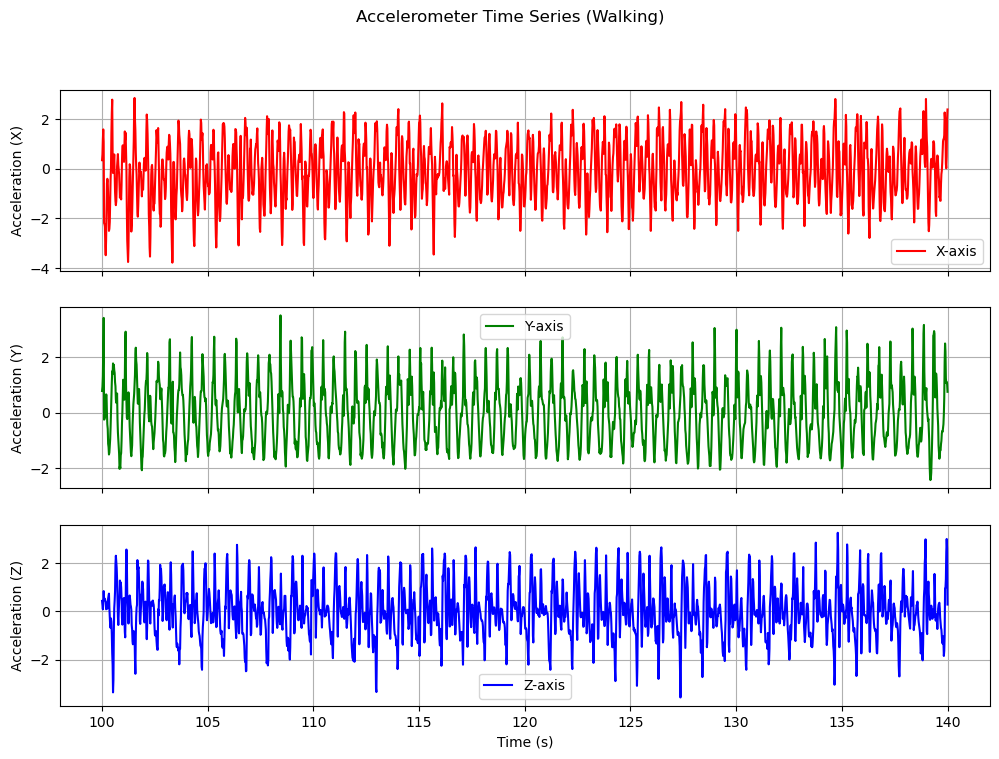

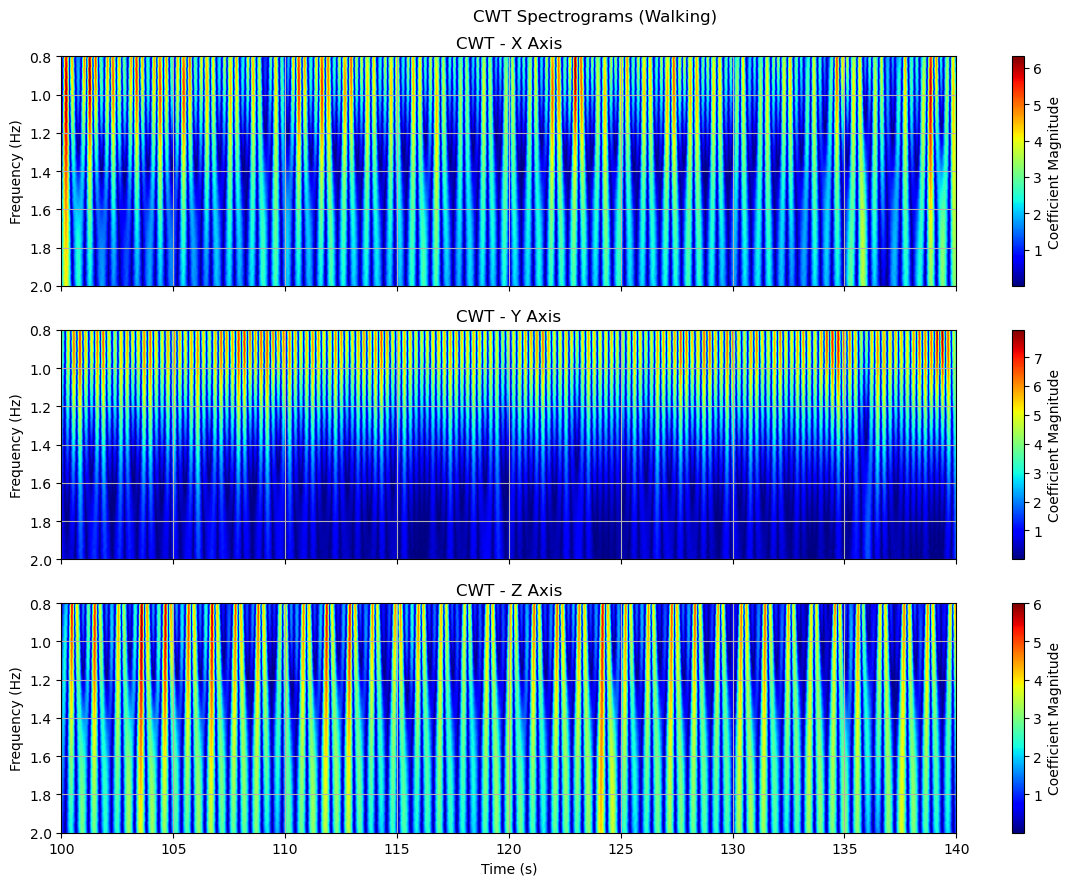

In [25]:
walking = walking[(walking['Time'] >= 100) & (walking['Time'] <= 140)]
plot_time_series(walking, "Walking")
plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

We can see better the activity of walking: each step is represented by a peak in the spectrogram but it is a bit noisy expecially in the time series. In order to remove the noise I will apply a low-pass filter.
A low-pass filter removes or reduces noise and high-frequency fluctuations from the signal, leaving behind the smoother, low-frequency trends. Accelerometer data often contains high-frequency noise due to sensor imperfections or external vibrations. A low-pass filter can remove this noise, making the signal cleaner and easier to analyze.

The code written above, in the same cell of `preprocess_data()` function, and reported below, implements the low-pass filter:


```python
def low_pass_filter(data, threshold = 1):
    b, a = scipy.signal.butter(8, threshold, 'low', fs=f)
    # Apply the filter to the data
    data['X'] = scipy.signal.filtfilt(b, a, data['X'])
    data['Y'] = scipy.signal.filtfilt(b, a, data['Y'])
    data['Z'] = scipy.signal.filtfilt(b, a, data['Z'])
    return data
```


`scipy.signal.butter()` designs a Butterworth low-pass filter.
The Butterworth filter is designed with a cutoff frequency of threshold Hz. Frequencies above this value are attenuated.
Parameters:
- `8`: The order of the filter. A higher order results in a faster attenuation of frequencies above the cutoff, but it can also introduce more distortion.
- `threshold:` The cutoff frequency in Hz. Frequencies above this value will be attenuated.
- `'low'`: Specifies that this is a low-pass filter.
- `fs=f`: The sampling frequency of the data (52 Hz in this case).

The output are `b` and `a` are the numerator and denominator coefficients of the filter. These define the filter’s behavior.
The use of the filter is enabled setting `low_pass=True` and specifying the threshold with `low_pass_freq` when calling `preprocess_data()`.
Applying the low-pass filter enfatizes the pattern of the walk (especially in the time series). We can see it in the spectrograms, looking at the thin vertical bands.

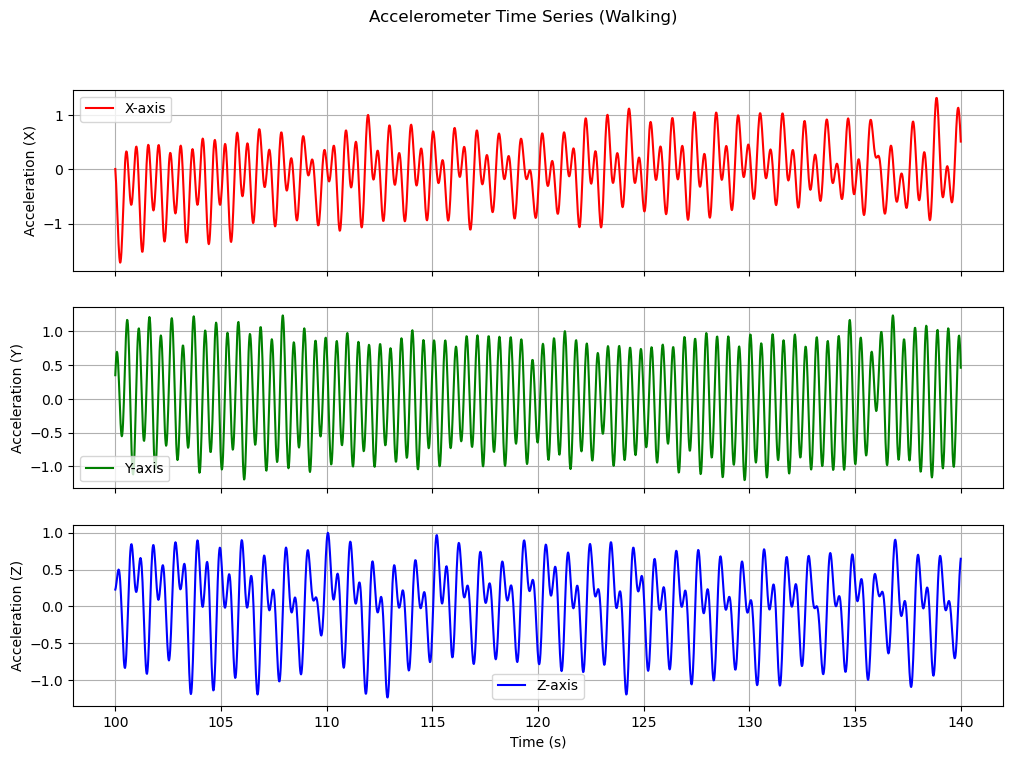

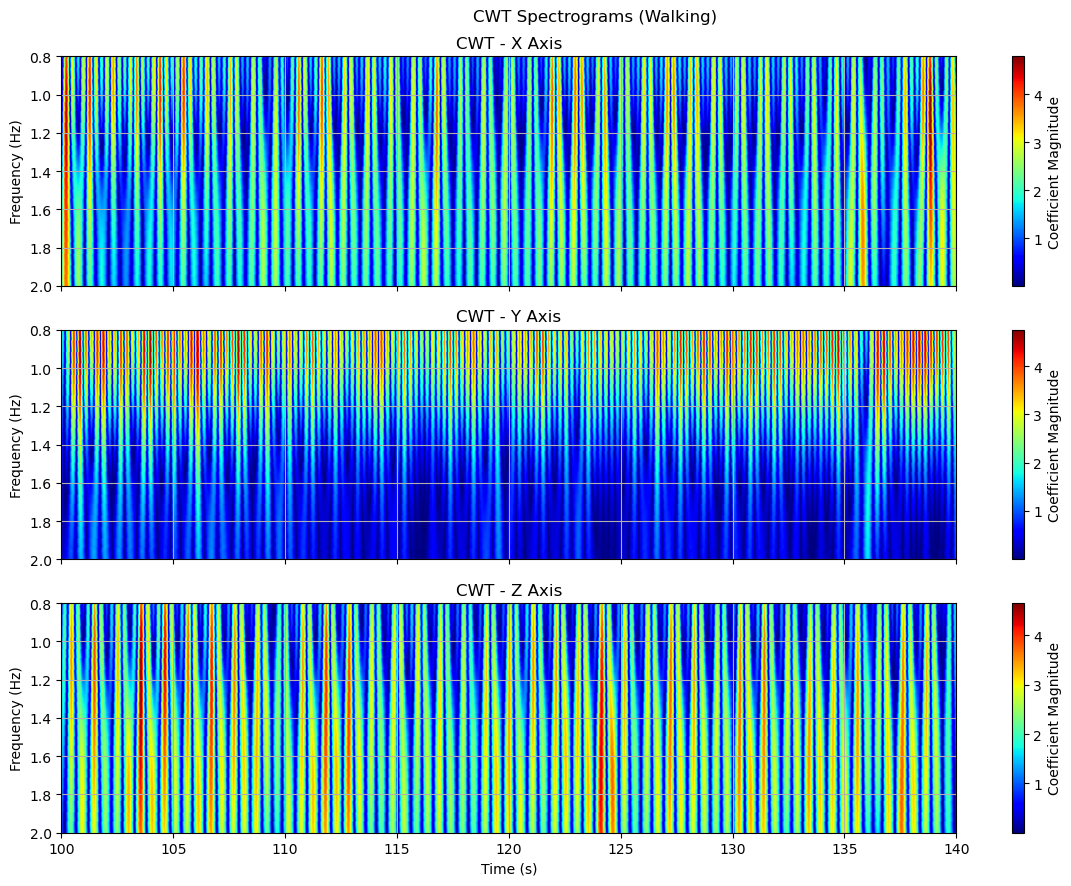

In [26]:
walking = data[data['Label'] == 4]
walking = preprocess_data(walking, low_pass=True, low_pass_freq=2)
walking = walking[(walking['Time'] >= 100) & (walking['Time'] <= 140)]
plot_time_series(walking, "Walking")
plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

Now, let's change activity: Going Up/Down stairs. I will apply directly a full `preprocess_data()` over the data

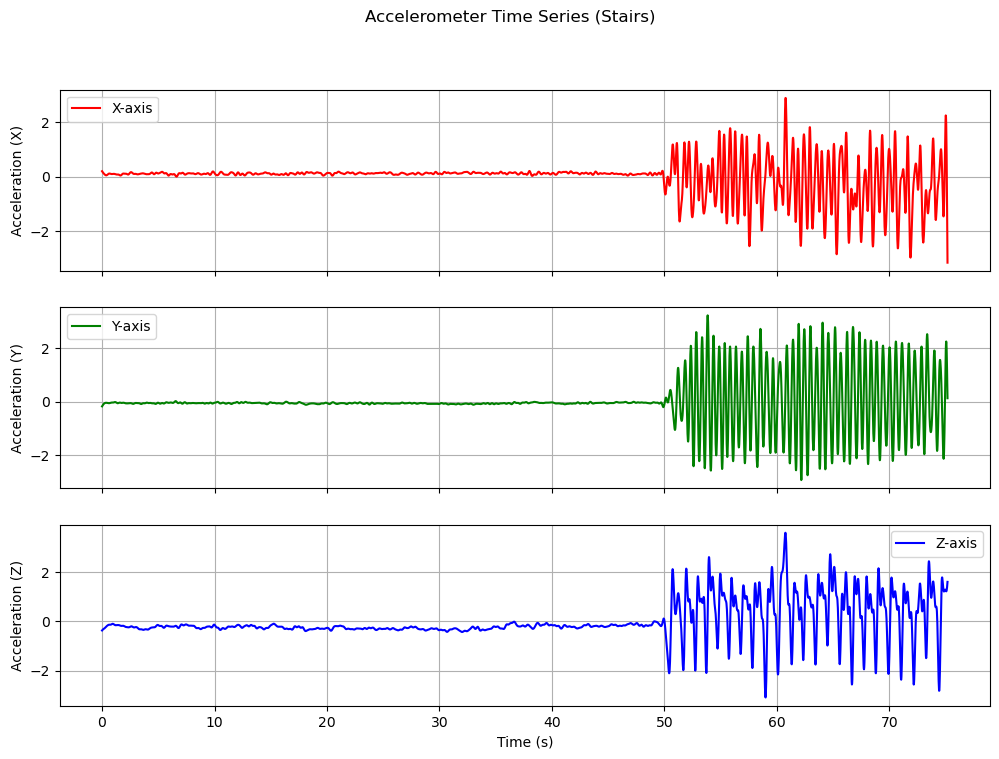

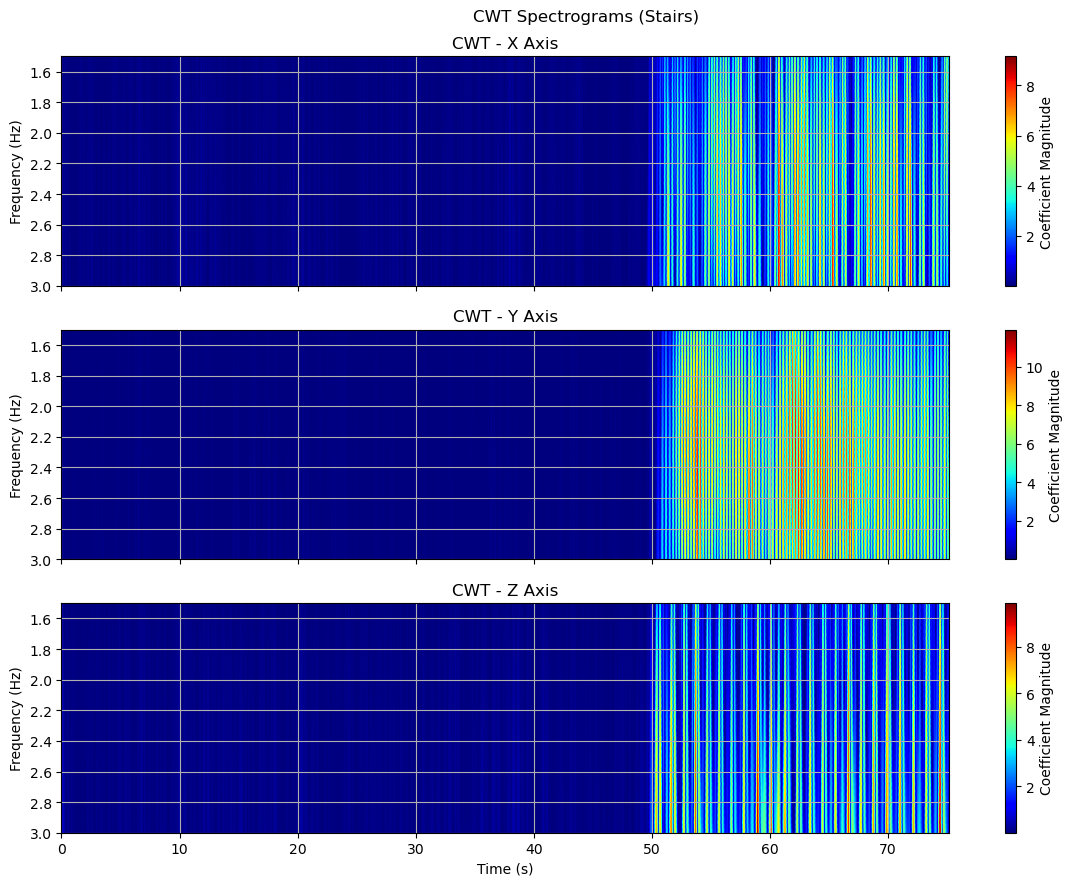

In [27]:
stairs = data[data['Label'] == 5]
stairs = preprocess_data(stairs, low_pass=True, low_pass_freq=3)
plot_time_series(stairs, "Stairs")
plot_cwt_spectrograms(stairs, sombrero, "Stairs", f_min=1.5, f_max=3)

Here we can see a portion of time where probably the subject was standing still and than around 50th second started to going up/down some stairs.

The following plots are about the other activities and for activities with a long time series I picked only a period of 40 seconds. We can see that activities with a well-paced rhythm like walking and going up/down stairs have similar patterns, with thin bands very close to each other. Calmer and less hectic activities instead have more zones where "nothing happens" and the detected activities are just small changes in speed because of little movements.

A strange spectrogram is the one computed for the activity of working at pc: there are two big triangular red zones at the edges of the plot, with nothing relevant between them. Probably is due to some accelerometer errors.

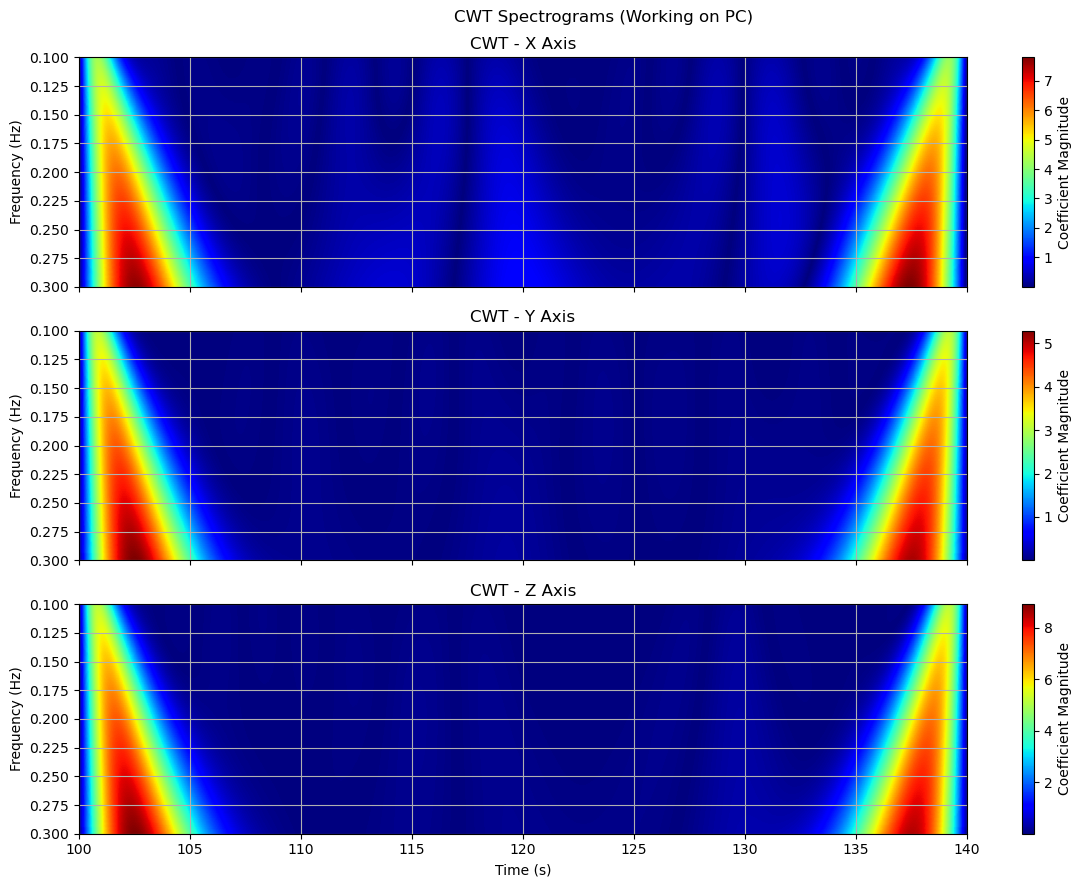

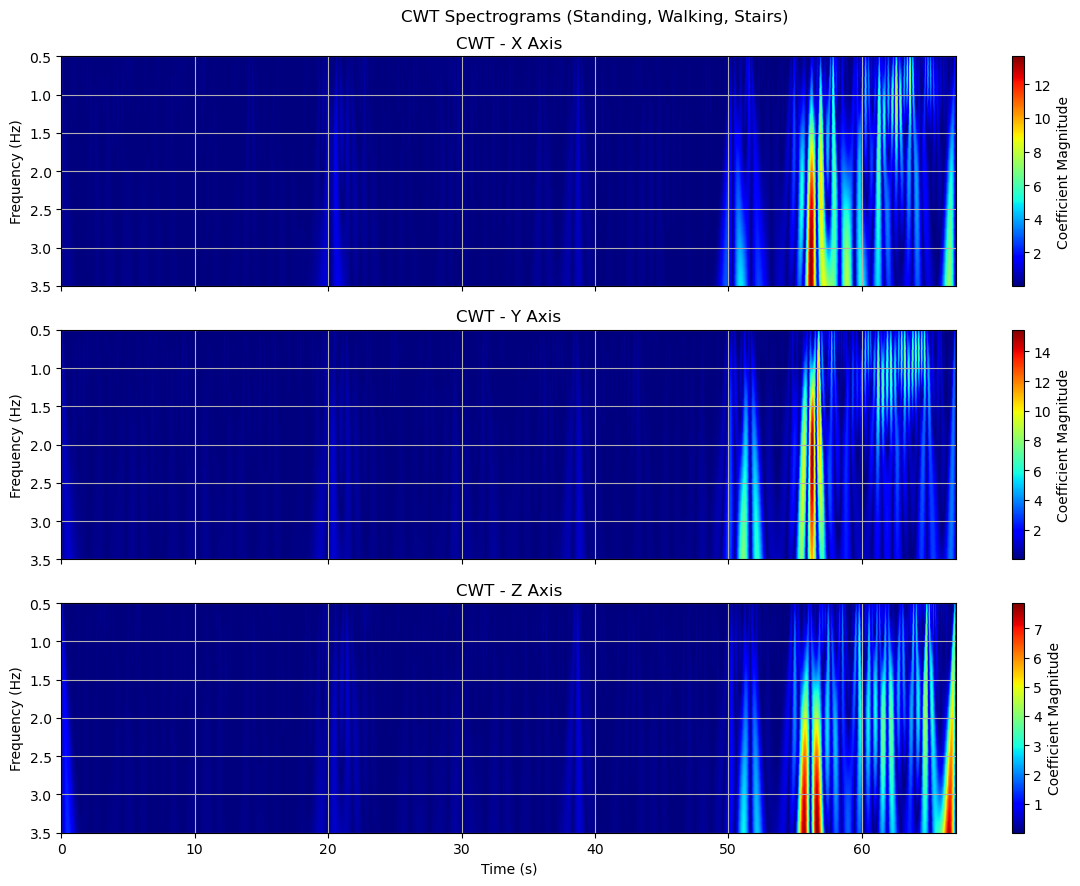

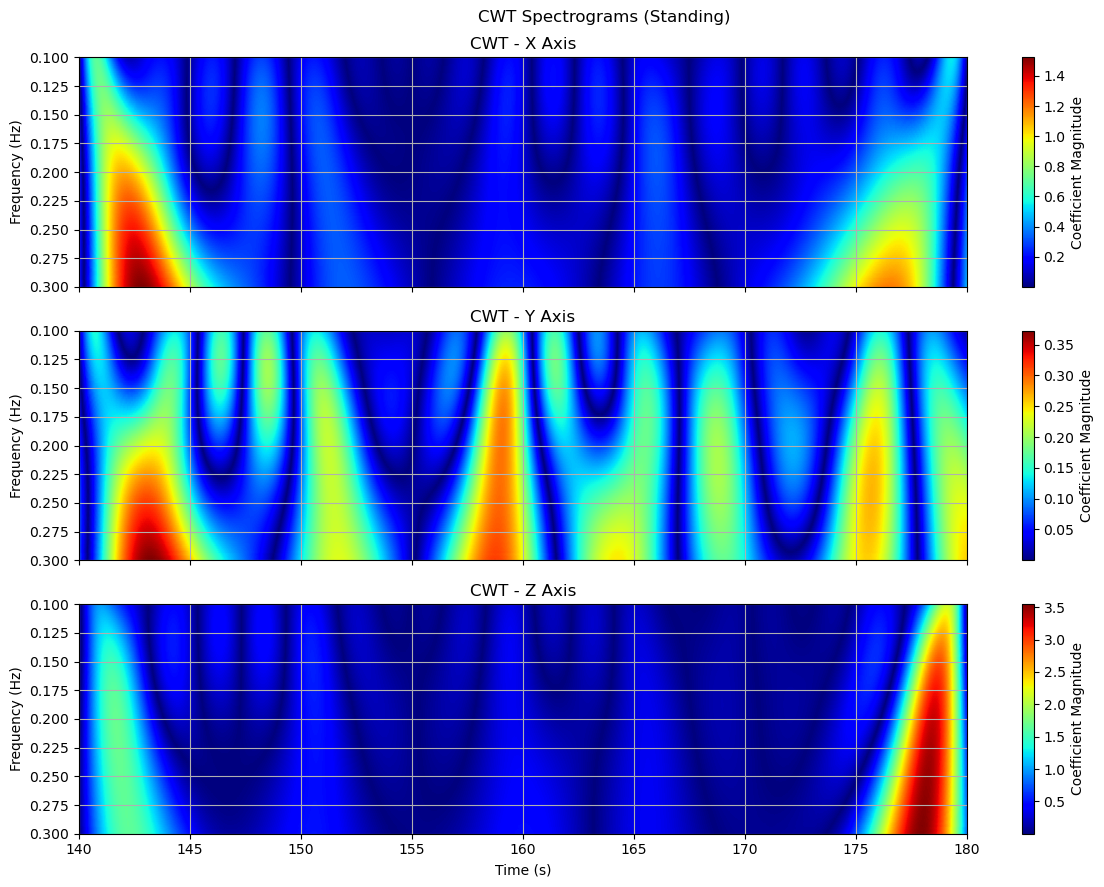

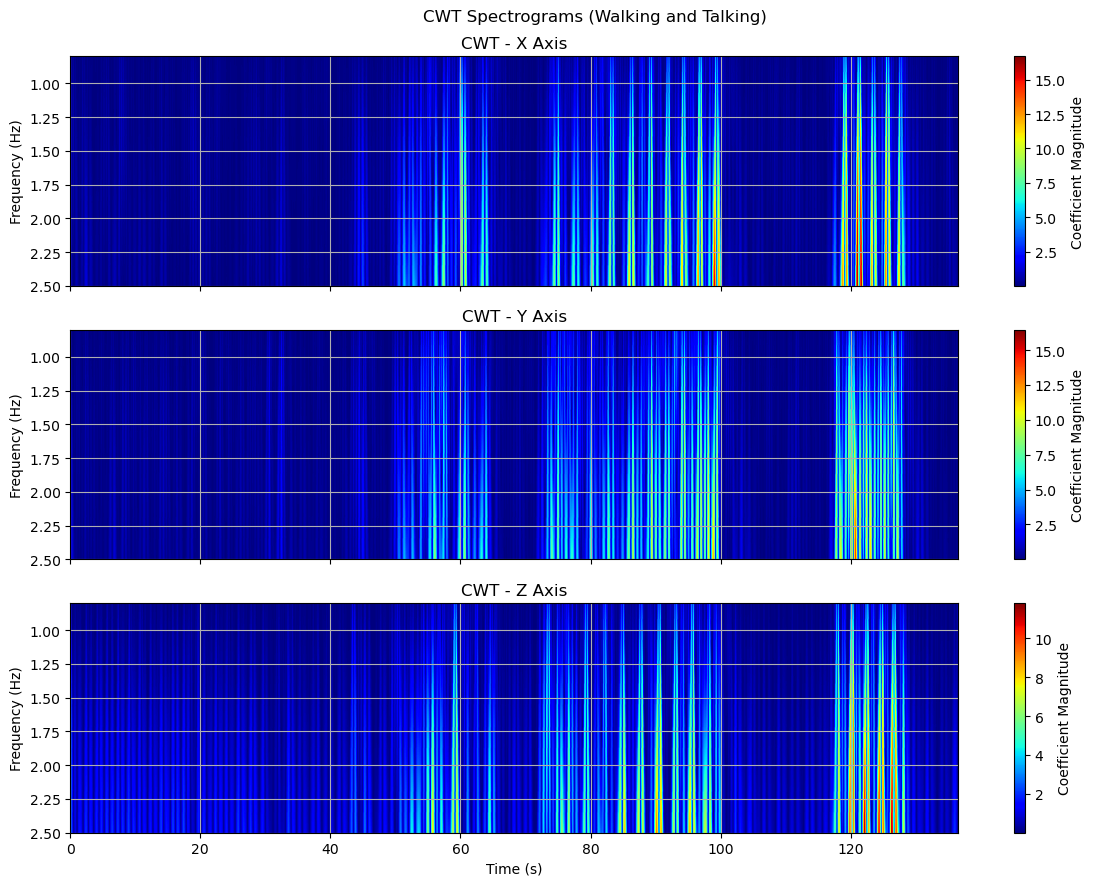

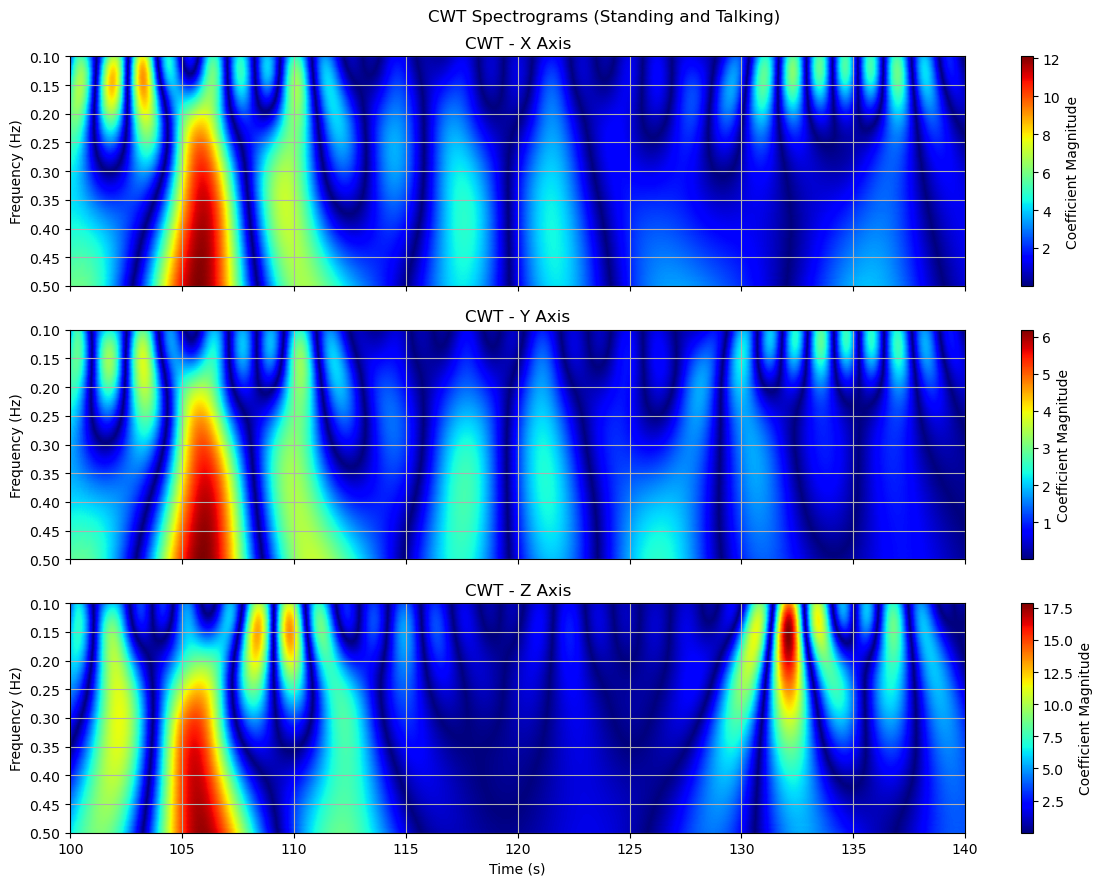

In [28]:
working_pc = data[data['Label'] == 1]
working_pc = preprocess_data(working_pc, low_pass=True, low_pass_freq=0.3)
working_pc = working_pc[(working_pc['Time'] >= 100) & (working_pc['Time'] <= 140)]
plot_cwt_spectrograms(working_pc, sombrero, "Working on PC", f_min=0.1, f_max=0.3)

standing_walking_stairs = data[data['Label'] == 2]
standing_walking_stairs = preprocess_data(standing_walking_stairs, low_pass=True, low_pass_freq=3.5)
plot_cwt_spectrograms(standing_walking_stairs, sombrero, "Standing, Walking, Stairs", f_min=0.5, f_max=3.5)

standing = data[data['Label'] == 3]
standing = preprocess_data(standing, low_pass=True, low_pass_freq=0.3)
standing = standing[(standing['Time'] >= 140) & (standing['Time'] <= 180)]
plot_cwt_spectrograms(standing, sombrero, "Standing", f_min=0.1, f_max=0.3)

walking_talking = data[data['Label'] == 6]
walking_talking = preprocess_data(walking_talking, low_pass=True, low_pass_freq=2.5)
plot_cwt_spectrograms(walking_talking, sombrero, "Walking and Talking", f_min=0.8, f_max=2.5)

standing_talking = data[data['Label'] == 7]
standing_talking = preprocess_data(standing_talking, low_pass=True, low_pass_freq=0.5)
standing_talking = standing_talking[(standing_talking['Time'] >= 100) & (standing_talking['Time'] <= 140)]
plot_cwt_spectrograms(standing_talking, sombrero, "Standing and Talking", f_min=0.1, f_max=0.5)

Finally, I decided to use an accelerometer to take data about two activities (walking and going up stairs) and analyze the signals to compare them with those of the dataset.

I used a simple accelerometer app for smartphone, uncalibrated and with a frequency sample of 100hz. Doing the measurements by myself and comparing the spectrograms obtained from the activities present in the dataset with mine, I can assume what was the accelerometer orientation used to acquire the data: X axis pointing right, Y axis pointing upward and Z axis pointing forward.

For my walking spectrogram, we can see the change of direction of the walk, looking at the blue areas between the green/red areas in the spectrogram of Y axis; for my going up stairs spectrogram instead, the blue areas (again in the Y axis spectrogram) indicate the presence of a landing between one flight of stairs and another.

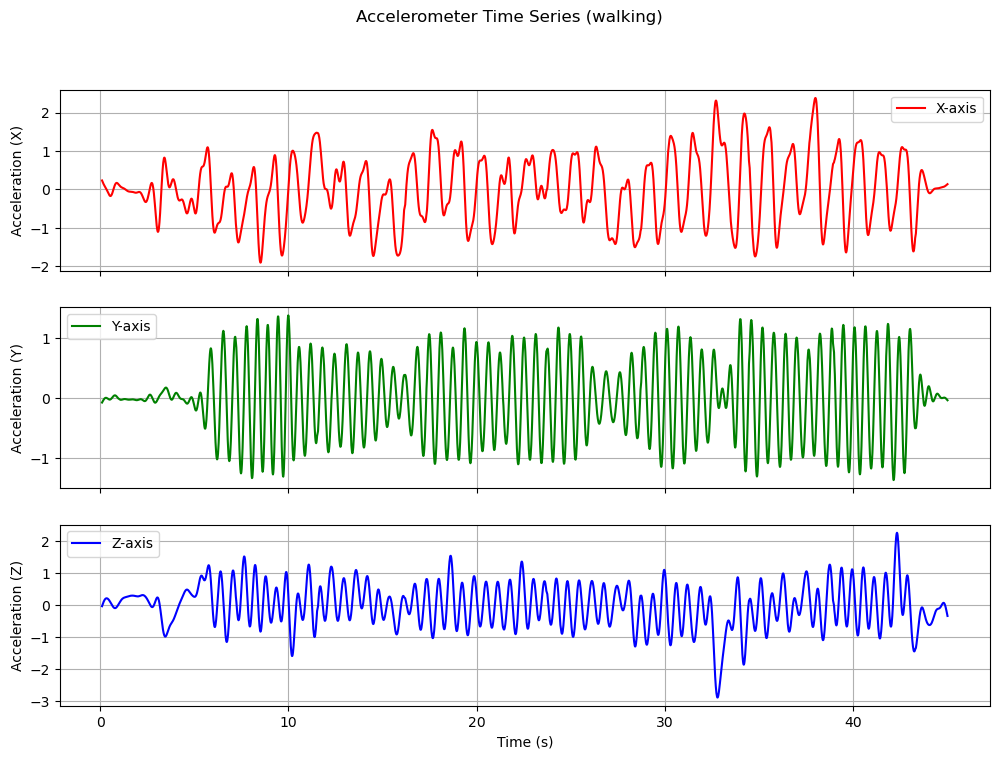

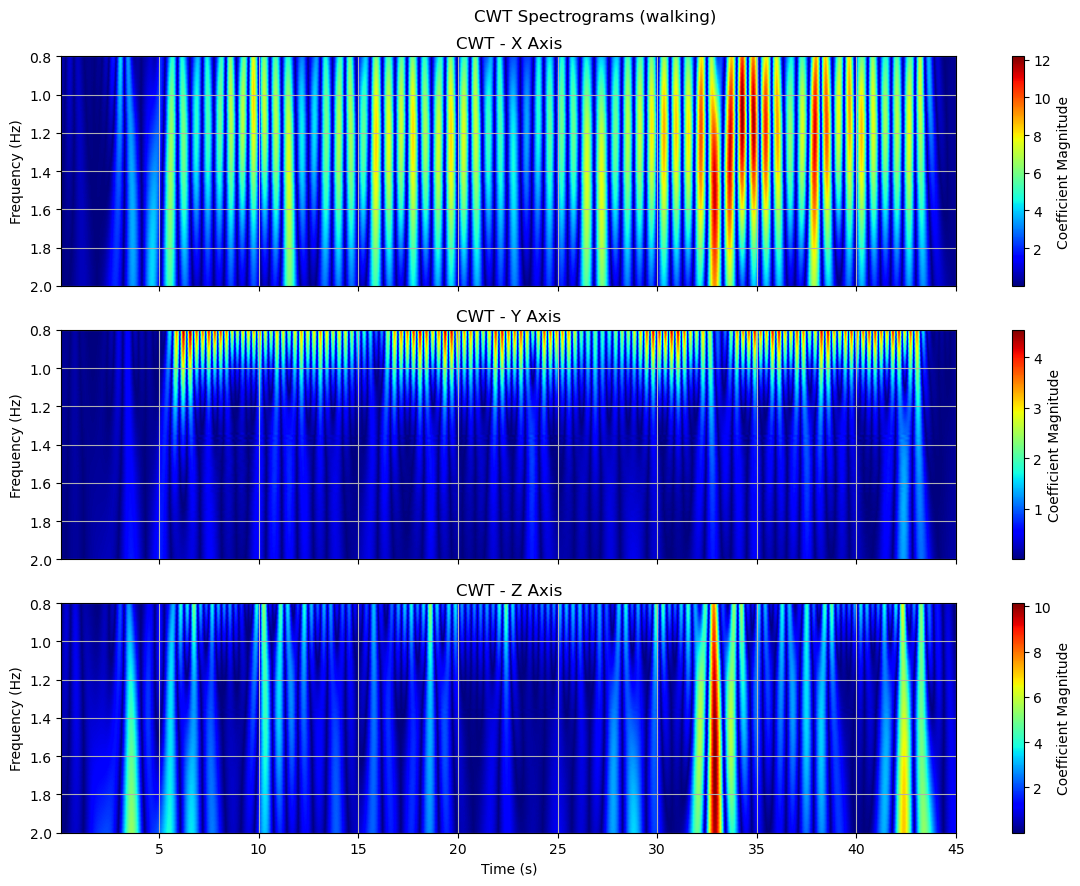

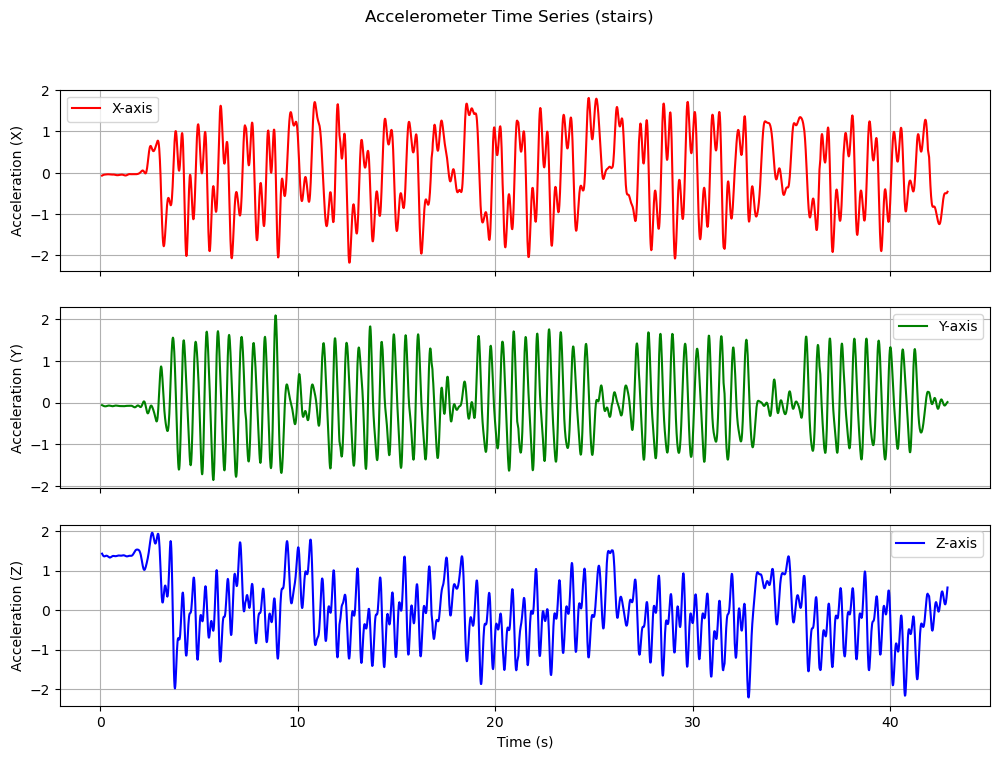

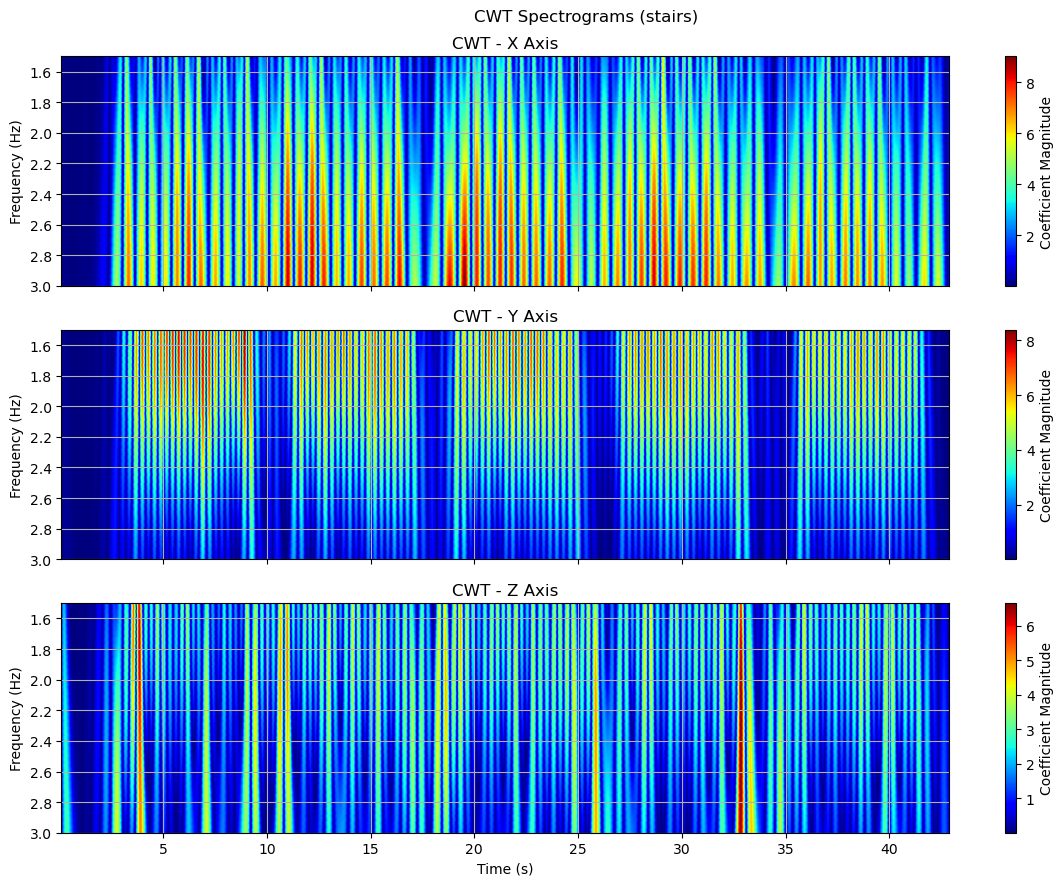

In [29]:
data_walking = pd.read_csv(f'./dataset/walking.csv')
data_stairs = pd.read_csv(f'./dataset/stairs.csv')

data_walking = preprocess_data(data_walking, low_pass=True, low_pass_freq=2)
data_stairs = preprocess_data(data_stairs, low_pass=True, low_pass_freq=3)

plot_time_series(data_walking, "walking")
plot_cwt_spectrograms(data_walking, sombrero, "walking", fs=100 ,f_min=0.8, f_max=2)

plot_time_series(data_stairs, "stairs")
plot_cwt_spectrograms(data_stairs, sombrero, "stairs", fs=100 ,f_min=1.5, f_max=3)